In [17]:
import pandas as pd

# import PyPDF2
import numpy as np

# import math
# from extractors.abstract_extractor import AbstractExractor
# from utils.data.visualisation import visualiseIndividualfromDF, visualiseIndividualinMPL
# from utils.misc.datastructure import perform_shape_switch
from tools.extraction_tools import (
    # extract_PDF_raw,
    # extract_leads_numeric,
    # move_trace_to_origin,
    # scale_values_using_cal_mark,
    # create_measurement_points,
    # perform_shape_switch,
    # adjust_leads_baseline,
    extract_traces,
)

# from tools.batch_extract_input import extract_traces
import multiprocessing

# import logging
# from tqdm import tqdm
from p_tqdm import p_map
import os
import re
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

<font color='green'>**Create list of EKG tracings to be read in**</font>

In [26]:
# source data (assumes data folder in working directory)
path_source = os.getcwd()

# data path
data_source = os.path.join(path_source, "data")

# data file list
data_paths = []
# walk through every case folder and extract initial EKG
for root, dirs, files in os.walk(data_source):
    for file in files:
        if file.endswith("_0.pdf"):
            data_paths.append(os.path.join(root, file))

# extract EKG TOXIC ID numbers and sort data_paths numerically
# initializing substrings
sub1 = "-"
sub2 = "_"
# regular expressions for respective sustrings
s = str(re.escape(sub1))
e = str(re.escape(sub2))


# EKG TOXIC end-digit ID label extractor
def label_extract(i):
    return int(re.findall(s + "(.*)" + e, os.path.basename(i))[0])


# sort EKG paths by TOXIC ID end-digit identifier using label_extract lambda
data_list = sorted(data_paths, key=label_extract)

# respective TOXIC ID labels for paths
ekg_labels = list(map(label_extract, data_paths))
# sort labels numerically
ekg_labels.sort()

Preprocess input features 

In [29]:
# Load input features and labels as dataframe
# feature path directory
feature_path = os.path.join(data_source, "input_features.xlsx")

# extract age, gender, initial EKG
# intial label to train on: expected dose of bupropion ingested
df_features = pd.read_excel(feature_path)

# list column names
feature_names = list(df_features)

# get indices of all columns in feature dataframe
feature_idx = [
    df_features.columns.get_loc(c) for c in feature_names if c in df_features
]

# merge column names and indices in one list
df_feature_col_idx = pd.DataFrame({"feature_name": feature_names, "idx": feature_idx})

# select input columns for training
df_input = df_features[
    [
        "toxIC ID",
        "Gender",
        "Age",
        "PR_initial",
        "QT_initial",
        "QTC_initial",
        "QRS_initial",
        "HR_initial",
        "Total ingestion (mg)",
    ]
]

# select only last identifier digits of TOXIC ID and cast as int
df_input.loc[:, "toxIC ID"] = df_input["toxIC ID"].str[7:].astype(int)

# sort by toxic ID
df_input.sort_values(by=["toxIC ID"])

,toxIC ID,Gender,Age,PR_initial,QT_initial,QTC_initial,QRS_initial,HR_initial,Total ingestion (mg)
4,8,F,58,122,348,414,86,85,900
9,22,F,42,154,372,479,84,100,600
12,45,M,31,140,362,489,96,110,0
19,80,M,16,128,394,383,100,57,0
0,118,F,23,140,448,416,88,52,0
1,119,F,23,146,356,415,78,82,200
2,122,M,22,182,368,440,92,86,1800
3,123,F,20,140,350,487,102,116,0
5,124,F,56,130,404,457,84,77,900
6,125,M,53,132,348,423,76,89,0


<font color='green'>**Import 12 lead (2.5s) for each subject**</font>


In [20]:
# use python multiprocessing to apply extraction function to each PDF across pool of workers
# p_map applies loading bar and multiprocessing to map function
with multiprocessing.Pool() as pool:
    df_output = p_map(extract_traces, data_list)

print(df_output)

100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


[            I       II     III     aVR    aVL     aVF     V1      V2      V3  \
0    -101.632  -90.896  10.816 -31.904  12.56  18.808  34.04 -41.816  14.872   
1     -97.632  -94.896   2.816 -40.904  35.56   0.808  31.04 -41.816  14.872   
2     -96.632 -108.896 -12.184 -45.904  36.56   9.808  26.04 -45.816  10.872   
3     -96.632 -100.896  -3.184 -50.904  36.56  13.808  25.04 -46.816  14.872   
4    -101.632 -100.896   1.816 -51.904  31.56  22.808  30.04 -46.816  10.872   
...       ...      ...     ...     ...    ...     ...    ...     ...     ...   
1245  -88.632  -76.896  10.816   2.096   2.56  -0.192  39.04 -16.816 -58.128   
1246  -92.632  -80.896  10.816   2.096   3.56  -5.192  38.04 -17.816 -62.128   
1247  -82.632  -81.896   1.816   2.096   7.56  -9.192  34.04 -21.816 -57.128   
1248  -67.632  -85.896 -17.184   7.096  -7.44   5.808  38.04 -22.816 -47.128   
1249  -67.632  -75.896  -7.184  12.096 -25.44  13.808  34.04 -27.816 -44.128   

        V4      V5     V6  
0    -25.2

<font color='green'>**Plot traces for each lead**</font>

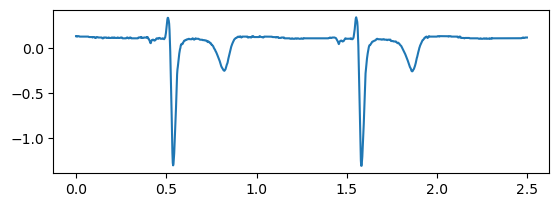

In [21]:
trace_input = df_output[3]
# Voltage scale
# 1000 points = 10 mm = 10cm = 1 mV => 1 point = 0.001 mV
# 10 mm/mV ==> 25 mm = 2.5 mV = 2500 points
voltage_arr = trace_input["V1"] * 0.001

# Time scale
# 1250 points = 2.5s ==> 1 point = 0.002s
# 25 mm/s =  25 mm = 1 s 500 points
# 1mm = 0.04s
time_arr = np.arange(0, 2.500, 0.002)

# Dell P3421W
# 109 PPI
# 43 ppcm
# pixel_pitch = 0.2325 mm
# 107.52 pixels = 25 mm = 1s

# Voltage/time aspect ration for 25 mm/s speed ()
aspect_ratio = 0.5

# Plot origin shifted traces
fig, ax = plt.subplots()
ax.plot(time_arr, voltage_arr)
ax.set_aspect(aspect_ratio)
plt.show()

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

<font color='green'>**Interactive plots**</font>

In [22]:
output_notebook()

p = figure(width=800, height=400)

# add a line renderer with NaN values
p.line(time_arr, voltage_arr, line_width=2)
p.xaxis.axis_label = "Time [s]"
p.yaxis.axis_label = "mV"

show(p)

Loading BokehJS ...